# **2BPerform inferCNV on simulated data**


In [ ]:
!pip install scanpy scipy umap-learn leidenalg scFates

In [ ]:
import scFates as scf
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

In [ ]:
!pip install infercnvpy


In [ ]:
import scanpy as sc
import infercnvpy as cnv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/compscfiles/adata_used.h5ad'
adata = ad.read_h5ad(file_path)

In [ ]:
adata.var

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,chromosome,start,end,strand,gene_name
original_index,,,,,,,,,,,,,,,
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,60,0.005183,99.490186,61.0,60,NaN,NaN,NaN,NaN,AL627309.1
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,4,0.000340,99.966012,4.0,4,1,89551.0,91105.0,-1.0,AL627309.3
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,False,False,679,0.062367,94.230606,734.0,673,1,778739.0,810066.0,1.0,AL669831.5
FAM87B,ENSG00000177757,Gene Expression,GRCh38,False,False,13,0.001190,99.889540,14.0,13,1,817363.0,819842.0,1.0,FAM87B
LINC00115,ENSG00000225880,Gene Expression,GRCh38,False,False,350,0.031269,97.026085,368.0,340,1,586945.0,827989.0,-1.0,LINC00115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,ENSG00000276256,Gene Expression,GRCh38,False,False,77,0.006882,99.345739,81.0,75,GL000195.1,42939.0,49164.0,-1.0,AC011043.1
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,False,False,32,0.002719,99.728099,32.0,31,GL000219.1,54224.0,83311.0,-1.0,AL592183.1
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,False,False,239,0.020902,97.969241,246.0,235,KI270734.1,131494.0,137392.0,1.0,AC007325.4


# Simulation of CNVs in the PMBC dataset provided

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import random
import os
import re

def simulate_limited_cnas(
    adata,
    target_percentage=30,  # Target percentage of cells with CNAs
    size_ranges=[(5, 20), (30, 100), (150, 300)],
    freq_ranges=[(0.05, 0.1), (0.2, 0.3), (0.4, 0.6)],
    random_seed=42
):
    """
    Simulate CNAs affecting only a subset of cells, limiting to standard chromosomes.

    Parameters
    ----------
    adata : AnnData
        Input dataset
    target_percentage : float
        Target percentage of cells to have CNAs (0-100)
    size_ranges : list of tuples
        Size ranges for CNAs (number of genes)
    freq_ranges : list of tuples
        Frequency ranges for CNAs within the target subset
    random_seed : int
        Random seed for reproducibility

    Returns
    -------
    adata_sim : AnnData
        Dataset with simulated CNAs
    """
    print("Starting targeted CNA simulation...")

    # Set seed for reproducibility
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Create a copy
    adata_sim = adata.copy()

    # Get expression matrix as numpy array
    if isinstance(adata_sim.X, np.ndarray):
        X = adata_sim.X.copy()
    else:
        X = adata_sim.X.toarray().copy()

    # Determine how many cells should have CNAs
    n_cells_total = adata_sim.n_obs
    n_cells_with_cnas = int(n_cells_total * target_percentage / 100)

    print(f"Target: {n_cells_with_cnas} out of {n_cells_total} cells will have CNAs ({target_percentage}%)")

    # Select cells to have CNAs
    cells_to_modify = random.sample(range(n_cells_total), n_cells_with_cnas)

    # Create a ground truth matrix just for tracking
    cna_matrix = np.zeros((adata_sim.n_obs, adata_sim.n_vars))

    # Filter for standard chromosomes (1-22, X, Y)
    standard_chroms = []
    for chrom in adata_sim.var['chromosome'].unique():
        chrom_str = str(chrom)
        # Match standard chromosomes with or without 'chr' prefix
        if re.match(r'^(chr)?([1-9]|1[0-9]|2[0-2]|X|Y)$', chrom_str, re.IGNORECASE):
            standard_chroms.append(chrom)

    print(f"Found {len(standard_chroms)} standard chromosomes: {standard_chroms}")

    # Group genes by chromosome using integer indices, but only for standard chromosomes
    chromosome_groups = {}
    for i, chrom in enumerate(adata_sim.var['chromosome']):
        if pd.isna(chrom) or chrom not in standard_chroms:
            continue

        if chrom not in chromosome_groups:
            chromosome_groups[chrom] = []
        chromosome_groups[chrom].append(i)

    # Track CNA info
    cna_info = []
    cna_id = 1

    # Cell annotations for simulated CNAs
    cell_cna_annotations = {}
    for i in range(adata_sim.n_obs):
        cell_cna_annotations[i] = []

    # Create CNAs for each combination, but limit to the selected cells
    for size_range in size_ranges:
        for freq_range in freq_ranges:
            print(f"Creating CNA with size {size_range} and frequency {freq_range}")

            # Find chromosomes with enough genes
            valid_chroms = []
            for chrom, gene_indices in chromosome_groups.items():
                if len(gene_indices) >= size_range[0]:
                    valid_chroms.append(chrom)

            if not valid_chroms:
                print(f"No chromosomes have enough genes for size {size_range}")
                continue

            # Select chromosome
            chrom = random.choice(valid_chroms)
            gene_indices = chromosome_groups[chrom]

            # Sort gene indices by position if position info available
            if 'start' in adata_sim.var.columns:
                gene_indices = sorted(gene_indices,
                                     key=lambda i: adata_sim.var['start'].iloc[i]
                                     if not pd.isna(adata_sim.var['start'].iloc[i]) else 0)

            # Determine CNA size
            cna_size = random.randint(
                size_range[0],
                min(size_range[1], len(gene_indices))
            )

            # Select starting position
            max_start = len(gene_indices) - cna_size
            start_idx = random.randint(0, max_start)

            # Get affected gene indices
            affected_indices = gene_indices[start_idx:start_idx + cna_size]

            # Determine CNA type
            is_gain = random.random() < 0.5
            cna_type = 'gain' if is_gain else 'loss'
            factor = 2.0 if is_gain else 0.5

            # Calculate how many cells should get this CNA within the target subset
            freq = random.uniform(freq_range[0], freq_range[1])
            n_affected_cells = int(len(cells_to_modify) * freq)

            # Select random cells from our target subset
            affected_cell_indices = random.sample(cells_to_modify, n_affected_cells)

            # Modify expression and record ground truth
            for gene_idx in affected_indices:
                # Modify expression
                X[affected_cell_indices, gene_idx] *= factor

                # Record in ground truth matrix
                value = 1 if is_gain else -1
                for cell_idx in affected_cell_indices:
                    cna_matrix[cell_idx, gene_idx] = value

            # Format chromosome label for cleaner display
            chrom_label = str(chrom).replace("chr", "").upper()

            # Record CNA info and update cell annotations
            cna_label = f"{cna_type}_{chrom_label}_{size_range[0]}-{size_range[1]}"

            for cell_idx in affected_cell_indices:
                cell_cna_annotations[cell_idx].append(cna_label)

            # Add to CNA info list
            if len(affected_indices) > 0:
                first_gene = affected_indices[0]
                last_gene = affected_indices[-1]

                start_pos = adata_sim.var['start'].iloc[first_gene] if 'start' in adata_sim.var.columns else None
                end_pos = adata_sim.var['end'].iloc[last_gene] if 'end' in adata_sim.var.columns else None

                cna_info.append({
                    'cna_id': f'CNA_{cna_id}',
                    'chromosome': chrom_label,
                    'start_pos': start_pos,
                    'end_pos': end_pos,
                    'size': len(affected_indices),
                    'size_range': f"{size_range[0]}-{size_range[1]}",
                    'frequency': freq,
                    'frequency_range': f"{freq_range[0]}-{freq_range[1]}",
                    'type': cna_type,
                    'n_affected_cells': n_affected_cells
                })

                cna_id += 1

    # Update the expression matrix
    adata_sim.X = X

    # Store the ground truth CNA matrix
    adata_sim.layers['ground_truth_cnas'] = cna_matrix

    # Add CNA info to uns
    adata_sim.uns['simulated_cnas_info'] = pd.DataFrame(cna_info)

    # Update the simulated_cnvs column - reset all to normal first
    new_annotations = ['normal'] * adata_sim.n_obs

    # Then update cells with CNAs
    for i, cell_cnas in cell_cna_annotations.items():
        if cell_cnas:  # If this cell has CNAs
            new_annotations[i] = ';'.join(cell_cnas)

    # Update the column
    adata_sim.obs['simulated_cnvs'] = new_annotations

    # Count cells with CNAs
    cells_with_cnas = sum(anno != 'normal' for anno in new_annotations)

    print(f"Simulation complete. Created {len(cna_info)} CNAs.")
    print(f"Cells with CNAs: {cells_with_cnas} out of {n_cells_total} "
          f"({cells_with_cnas / n_cells_total * 100:.1f}%)")

    # List all simulated CNAs
    print("\nList of simulated CNAs:")
    for i, cna in enumerate(cna_info):
        print(f"CNA {i+1}: {cna['type']} on chromosome {cna['chromosome']}, "
              f"size: {cna['size']} genes ({cna['size_range']}), "
              f"frequency: {cna['frequency']:.2f} ({cna['frequency_range']})")

    return adata_sim



# Reset existing CNVs
print("Resetting existing CNVs...")
adata.obs['simulated_cnvs'] = 'normal'

# Run simulation with only 30% of cells having CNAs and only on standard chromosomes
adata_sim = simulate_limited_cnas(
    adata,
    target_percentage=30,  # Only 30% of cells will have CNAs
    size_ranges=[(5, 20), (30, 100), (150, 300)],
    freq_ranges=[(0.05, 0.1), (0.2, 0.3), (0.4, 0.6)]
)

# Save results
save_dir = "/content/drive/My Drive/compscfiles/simulated_anndatanew"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "standard_chrom_cnvs.h5ad")
print(f"Saving simulated data to {save_path}...")
adata_sim.write(save_path)

print("Simulation with standard chromosome CNVs completed!")

Resetting existing CNVs...
Starting targeted CNA simulation...
Target: 3092 out of 10309 cells will have CNAs (30%)
Found 24 standard chromosomes: ['1', '2', '3', '4', '5', '6', '7', 'X', '8', '9', '11', '10', '12', '13', '14', '15', '16', '17', '18', '20', '19', 'Y', '22', '21']
Creating CNA with size (5, 20) and frequency (0.05, 0.1)
Creating CNA with size (5, 20) and frequency (0.2, 0.3)
Creating CNA with size (5, 20) and frequency (0.4, 0.6)
Creating CNA with size (30, 100) and frequency (0.05, 0.1)
Creating CNA with size (30, 100) and frequency (0.2, 0.3)
Creating CNA with size (30, 100) and frequency (0.4, 0.6)
Creating CNA with size (150, 300) and frequency (0.05, 0.1)
Creating CNA with size (150, 300) and frequency (0.2, 0.3)
Creating CNA with size (150, 300) and frequency (0.4, 0.6)
Simulation complete. Created 9 CNAs.
Cells with CNAs: 2942 out of 10309 (28.5%)

List of simulated CNAs:
CNA 1: gain on chromosome 22, size: 9 genes (5-20), frequency: 0.08 (0.05-0.1)
CNA 2: loss o

In [ ]:
adata_sim

AnnData object with n_obs × n_vars = 10309 × 20104
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'cell_type', 'simulated_cnvs'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'chromosome', 'start', 'end', 'strand', 'gene_name'
    uns: 'simulated_cnas_info'
    layers: 'counts', 'ground_truth_cnas'

# Installing R Dependencies to run inferCNV on the simulated data

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# Create output directory for results
out_dir = "/content/drive/My Drive/compscfiles/simulated_anndatanew/inferCNV_results"
os.makedirs(out_dir, exist_ok=True)

# Install R on Colab if not already installed
print("Installing R and dependencies...")
!apt-get update -qq
!apt-get install -y --no-install-recommends r-base r-base-dev libcurl4-openssl-dev libxml2-dev libssl-dev jags

# Install rpy2 if not already installed
!pip install rpy2

# Now import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

# Load the simulated data
print("Loading data with limited CNAs...")
adata_sim_visual = sc.read_h5ad('/content/drive/My Drive/compscfiles/simulated_anndatanew/standard_chrom_cnvs.h5ad')

# Setup R environment
print("Setting up R environment...")
# Initialize R
r = ro.r

# Install and load required R packages
print("Installing necessary R packages (this may take a while)...")
# Install BiocManager
r('if (!require("BiocManager", quietly = TRUE)) install.packages("BiocManager")')
# Install inferCNV
r('BiocManager::install("infercnv", dependencies=TRUE)')
# Load inferCNV
r('library(infercnv)')
print("R packages installed and loaded successfully")

# Prepare data for inferCNV
print("Preparing data for inferCNV...")


Installing R and dependencies...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcurl4-openssl-dev is already the newest version (7.81.0-1ubuntu1.20).
libssl-dev is already the newest version (3.0.2-0ubuntu1.19).
libxml2-dev is already the newest version (2.9.13+dfsg-1ubuntu0.7).
jags is already the newest version (4.3.2-1.2204.0).
r-base-dev is already the newest version (4.5.0-3.2204.0).
r-base is already the newest version (4.5.0-3.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Loading data with limited CNAs...
Setting up R environment...
Installing necessary R packages (this may take a while)...
Update all/some/none? [a/s/n]: a
R packages installed and loaded successfully
Preparing data for inferCNV...


# InferCNV run

In [ ]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

# Create output directory (with NO spaces in the path)
out_dir = "/content/drive/My Drive/compscfiles/inferCNV_out"  # Simple path with no spaces
os.makedirs(out_dir, exist_ok=True)

# Load the data
print("Loading simulated CNV data...")
adata_sim_visual = sc.read_h5ad('/content/drive/My Drive/compscfiles/simulated_anndatanew/standard_chrom_cnvs.h5ad')

# Subsample for faster processing
n_cells = 2000
print(f"Subsampling to {n_cells} cells...")
np.random.seed(42)  # For reproducibility
cell_indices = np.random.choice(adata_sim_visual.obs_names, size=n_cells, replace=False)
adata_subset = adata_sim_visual[cell_indices].copy()

# Export count matrix
print("Exporting count matrix...")
if 'counts' in adata_subset.layers:
    counts = pd.DataFrame(
        adata_subset.layers['counts'].toarray()
        if hasattr(adata_subset.layers['counts'], 'toarray')
        else adata_subset.layers['counts'],
        index=adata_subset.obs_names,
        columns=adata_subset.var_names
    )
else:
    counts = pd.DataFrame(
        adata_subset.X.toarray()
        if hasattr(adata_subset.X, 'toarray')
        else adata_subset.X,
        index=adata_subset.obs_names,
        columns=adata_subset.var_names
    )

counts_file = os.path.join(out_dir, "counts.txt")
counts.to_csv(counts_file, sep='\t')

# Export cell annotations
print("Exporting cell annotations...")
annotations = pd.DataFrame(index=adata_subset.obs_names)
annotations['cell_type'] = adata_subset.obs['simulated_cnvs']
annotations_file = os.path.join(out_dir, "annotations.txt")
annotations.to_csv(annotations_file, sep='\t', header=False)

# Export gene positions
print("Exporting gene positions...")
gene_order = adata_subset.var[['chromosome', 'start', 'end']].copy()
gene_order.index.name = 'gene'
gene_order.reset_index(inplace=True)
gene_order_file = os.path.join(out_dir, "gene_order.txt")
gene_order.to_csv(gene_order_file, sep='\t', index=False)

# Create R script that references local files directly
r_script = """
library(infercnv)

# Create the inferCNV object
infercnv_obj <- CreateInfercnvObject(
    raw_counts_matrix="counts.txt",
    annotations_file="annotations.txt",
    gene_order_file="gene_order.txt",
    ref_group_names="normal"
)

# Run inferCNV
infercnv_obj <- run(
    infercnv_obj,
    cutoff=0.1,
    out_dir="./",
    cluster_by_groups=TRUE,
    denoise=TRUE,
    HMM=FALSE,
    analysis_mode="samples",
    num_threads=2,
    no_plot=FALSE
)

# Save the inferCNV object
saveRDS(infercnv_obj, file="infercnv_obj.rds")

print("inferCNV analysis completed successfully")
"""

r_script_path = os.path.join(out_dir, "run_infercnv.R")
with open(r_script_path, 'w') as f:
    f.write(r_script)

# Create a proper shell script with quoted paths
shell_script = """#!/bin/bash
cd "{0}"
Rscript run_infercnv.R
""".format(out_dir)

shell_script_path = os.path.join(out_dir, "run.sh")
with open(shell_script_path, 'w') as f:
    f.write(shell_script)

# Make executable
!chmod +x "{shell_script_path}"

# Run the analysis from the current directory
print("Executing inferCNV analysis...")
!cd "{out_dir}" && Rscript run_infercnv.R

# Print summary of results
print("\nCNA Analysis Summary:")
print(f"Data processed: {n_cells} cells")
print(f"Results saved to: {out_dir}")

# Check what files were created
!ls -la "{out_dir}"

print("Analysis complete")

Loading simulated CNV data...
Subsampling to 2000 cells...
Exporting count matrix...
Exporting cell annotations...
Exporting gene positions...
Executing inferCNV analysis...
INFO [2025-05-05 21:35:27] Parsing matrix: counts.txt
INFO [2025-05-05 21:36:04] Parsing gene order file: gene_order.txt
INFO [2025-05-05 21:36:04] Parsing cell annotations file: annotations.txt
Error in CreateInfercnvObject(raw_counts_matrix = "counts.txt", annotations_file = "annotations.txt",  : 
  Please make sure that all the annotated cell  names match a sample in your data matrix.  Attention to:  TTTCATGGTAGCTAAA-1,GCCAGGTCAGGTCTCG-1,AAGCCATTCCATTGTT-1,TGATGCAGTCTTCAAG-1,TCGCACTGTTGATGTC-1,AAAGGATAGTGAATAC-1,CTCATTAAGCTTTCTT-1,TCGTCCACAGTCGGTC-1,AAGAACAAGTCTCCTC-1,ACATTTCTCAAAGAAC-1,ACATGCAGTACCCGAC-1,CCGGTAGTCACGACTA-1,TAACTTCAGCGACTGA-1,ACACAGTCATGGATCT-1,CAGTTCCAGCGTCGAA-1,ATTCAGGTCGTTACCC-1,AAAGAACGTCTCGGGT-1,TGATCAGCAGTAACCT-1,ACTTCGCGTAGAGCTG-1,TCGCTTGCACCAGGTC-1,CCACTTGTCTTAGCCC-1,GGAGAACCAAAGAGTT-1,G

Loading the simulated CNV data...
Found 7367 normal cells and 2942 cells with CNAs
Processing expression data...
Filtered to 24 standard chromosomes: ['1', '2', '3', '4', '5', '6', '7', 'X', '8', '9', '11', '10', '12', '13', '14', '15', '16', '17', '18', '20', '19', 'Y', '22', '21']
Creating CNA heatmap...
Creating chromosome-level summary...


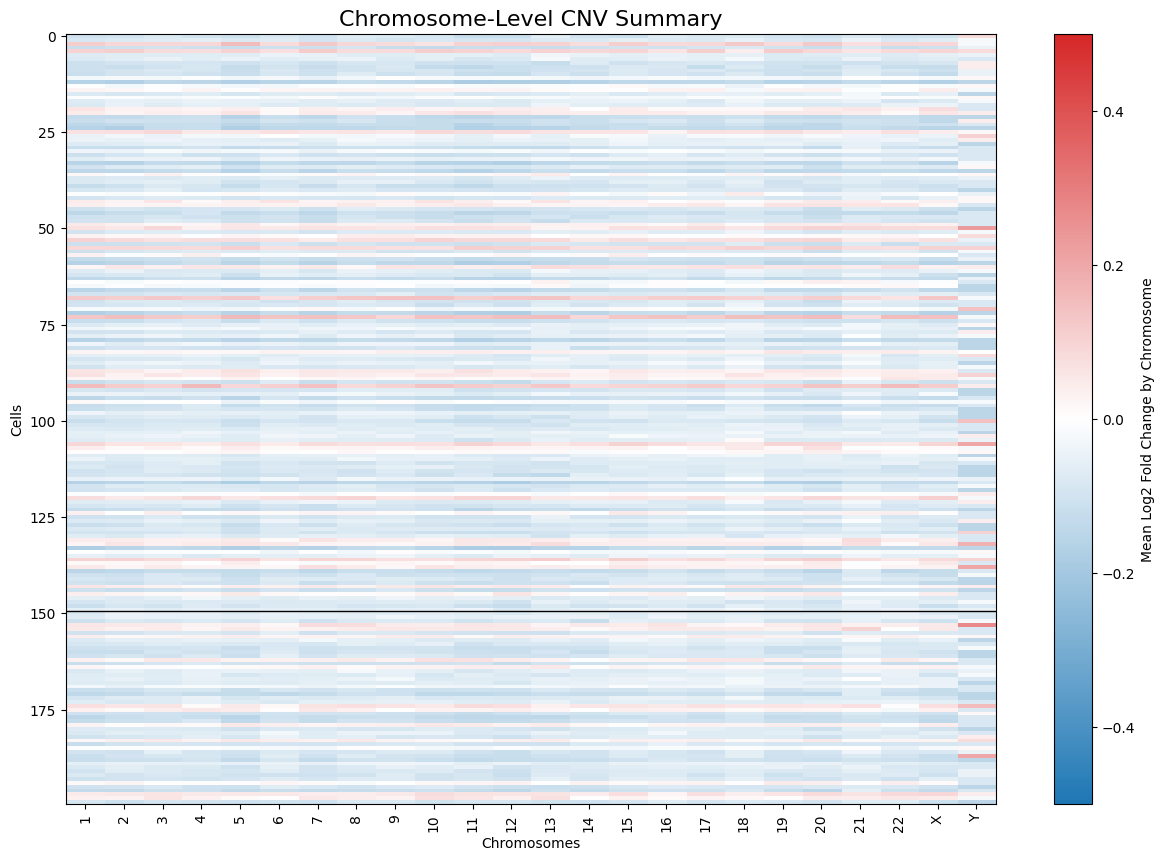

Visualizations saved to /content/drive/My Drive/compscfiles/inferCNV_viz
Done!


In [ ]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import re

# Set output paths
viz_dir = "/content/drive/My Drive/compscfiles/inferCNV_viz"
os.makedirs(viz_dir, exist_ok=True)

# Load your data
print("Loading the simulated CNV data...")
adata_sim_visual = sc.read_h5ad('/content/drive/My Drive/compscfiles/simulated_anndatanew/standard_chrom_cnvs.h5ad')

# Identify normal and CNA cells
is_normal = adata_sim_visual.obs['simulated_cnvs'] == 'normal'
normal_cells = adata_sim_visual.obs_names[is_normal]
cna_cells = adata_sim_visual.obs_names[~is_normal]
print(f"Found {len(normal_cells)} normal cells and {len(cna_cells)} cells with CNAs")

# Extract expression data
print("Processing expression data...")
if 'counts' in adata_sim_visual.layers:
    expr = (
        adata_sim_visual.layers['counts'].toarray()
        if hasattr(adata_sim_visual.layers['counts'], 'toarray')
        else adata_sim_visual.layers['counts']
    )
else:
    expr = (
        adata_sim_visual.X.toarray()
        if hasattr(adata_sim_visual.X, 'toarray')
        else adata_sim_visual.X
    )

# Create DataFrame with cell names as index
expr_df = pd.DataFrame(
    expr,
    index=adata_sim_visual.obs_names,
    columns=adata_sim_visual.var_names
)

# Calculate mean of normal cells
normal_mean = expr_df.loc[normal_cells].mean()

# Calculate log2 fold change (add 1 to avoid log(0))
log_fc = np.log2((expr_df + 1) / (normal_mean + 1))

# Filter for standard chromosomes (1-22, X, Y) only
standard_chroms = []
for chrom in adata_sim_visual.var['chromosome'].unique():
    if pd.notna(chrom):
        chrom_str = str(chrom)
        # Match chromosomes 1-22, X, Y with or without 'chr' prefix
        if re.match(r'^(chr)?([1-9]|1[0-9]|2[0-2]|X|Y)$', chrom_str, re.IGNORECASE):
            standard_chroms.append(chrom)

print(f"Filtered to {len(standard_chroms)} standard chromosomes: {standard_chroms}")

# Create chromosome ordering
def chrom_order(x):
    x = str(x).upper().replace('CHR', '')
    if x.isdigit():
        return int(x)
    elif x == 'X':
        return 23
    elif x == 'Y':
        return 24
    else:
        return 100

# Sort standard chromosomes naturally
chromosomes = sorted(standard_chroms, key=chrom_order)

# Create ordered gene list
ordered_genes = []
chr_boundaries = []
chr_labels = []
current_pos = 0

for chrom in chromosomes:
    # Get genes for this chromosome in position order
    chr_mask = adata_sim_visual.var['chromosome'] == chrom
    if chr_mask.sum() > 0:
        chr_genes = adata_sim_visual.var[chr_mask].sort_values('start').index.tolist()

        # Record chromosome boundary
        chr_boundaries.append(current_pos)
        chr_labels.append((current_pos + len(chr_genes)//2, str(chrom).replace('chr', '')))

        # Add genes to ordered list
        ordered_genes.extend(chr_genes)
        current_pos += len(chr_genes)

# Create visualization 1: Heatmap of CNAs
print("Creating CNA heatmap...")
# Sample cells for visualization
max_cna_cells = min(150, len(cna_cells))
max_normal_cells = min(50, len(normal_cells))

sampled_cna = np.random.choice(cna_cells, max_cna_cells, replace=False)
sampled_normal = np.random.choice(normal_cells, max_normal_cells, replace=False)
cells_to_plot = np.concatenate([sampled_cna, sampled_normal])

# Clip extreme values for visualization
log_fc_capped = log_fc.clip(-1.5, 1.5)

# Create figure
plt.figure(figsize=(20, 12))
heatmap_data = log_fc_capped.loc[cells_to_plot, ordered_genes]

# Create custom colormap (blue=deletions, red=amplifications)
cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    ['#1e77b4', '#ffffff', '#d62728'],  # blue, white, red
    N=256
)

# Plot heatmap
im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add chromosome boundaries
for boundary in chr_boundaries[1:]:  # Skip the first boundary at 0
    plt.axvline(x=boundary, color='black', linestyle='-', linewidth=0.5)

# Add chromosome labels
for pos, label in chr_labels:
    plt.text(pos, -5, label, ha='center', fontsize=10, weight='bold')

# Add separation line between CNA and normal cells
plt.axhline(y=max_cna_cells - 0.5, color='black', linestyle='-', linewidth=1)

# Add labels for cell types
plt.text(len(ordered_genes) + 5, max_cna_cells/2, 'Cells with CNAs',
         rotation=270, va='center', fontsize=12)
plt.text(len(ordered_genes) + 5, max_cna_cells + max_normal_cells/2, 'Normal Cells',
         rotation=270, va='center', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, orientation='vertical', pad=0.01)
cbar.set_label('Log2 Fold Change vs Normal Cells')

# Add title and labels
plt.title('Copy Number Variation Heatmap (Simulated CNVs)', fontsize=16)
plt.xlabel('Genes (ordered by chromosomal position)')
plt.ylabel('Cells')

# Remove x-ticks (too many genes)
plt.xticks([])

# Save figure
heatmap_file = os.path.join(viz_dir, 'cnv_heatmap.png')
plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
plt.close()

# Create visualization 2: Chromosome-level summary
print("Creating chromosome-level summary...")
chrom_data = pd.DataFrame(index=log_fc.index)

for chrom in chromosomes:
    # Get genes for this chromosome
    chr_genes = adata_sim_visual.var[adata_sim_visual.var['chromosome'] == chrom].index
    if len(chr_genes) > 0:
        # Calculate mean log FC by chromosome
        chrom_data[chrom] = log_fc[chr_genes].mean(axis=1)

# Create the heatmap
plt.figure(figsize=(15, 10))
chrom_data_capped = chrom_data.clip(-0.8, 0.8)
chrom_plot = chrom_data_capped.loc[cells_to_plot]

# Plot heatmap
im = plt.imshow(chrom_plot, cmap=cmap, aspect='auto', vmin=-0.5, vmax=0.5)

# Add a line to separate CNA and normal cells
plt.axhline(y=max_cna_cells - 0.5, color='black', linestyle='-', linewidth=1.0)

# Format chromosome labels - remove 'chr' prefix for cleaner display
chrom_labels = [str(c).replace('chr', '') for c in chrom_data.columns]

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Mean Log2 Fold Change by Chromosome')

# Add labels
plt.title('Chromosome-Level CNV Summary', fontsize=16)
plt.ylabel('Cells')
plt.xlabel('Chromosomes')
plt.xticks(range(len(chrom_labels)), chrom_labels, rotation=90)

# Save the visualization
summary_file = os.path.join(viz_dir, 'chromosome_summary.png')
plt.savefig(summary_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualizations saved to {viz_dir}")

# Outputs also saved to annotations.txt